<a href="https://www.kaggle.com/code/goktani/water-bottle-liquid-level-classification-cnn?scriptVersionId=292903479" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

**Importing Libraries and Checking Data**

In this step, we import the necessary libraries for file handling and verify that the dataset path is correct.

In [1]:
# Import necessary libraries for file handling and linear algebra
import numpy as np 
import pandas as pd 
import os

# Define the main dataset directory
# IMPORTANT: Check if this path matches your Kaggle dataset name
dataset_path = "/kaggle/input/water-bottle-dataset"

# List the class labels found in the dataset directory
try:
    labels = os.listdir(dataset_path)
    print("Detected Labels:", labels)

    # Print contents of each label folder to verify data exists
    for label in labels:
        print(f"Checking {label}:", os.listdir(os.path.join(dataset_path, label))[:5]) # Show first 5 files
except FileNotFoundError:
    print("Error: Dataset path is incorrect. Please check the Input path on Kaggle.")

Detected Labels: ['Full  Water level', 'Half water level', 'Overflowing']
Checking Full  Water level: ['Full  Water level']
Checking Half water level: ['Half water level']
Checking Overflowing: ['Overflowing']


**Creating Train and Validation Splits**

We need to split the data into training (80%) and validation (20%) sets. Since the original dataset is read-only, we copy the files into the /kaggle/working/ directory.

In [2]:
import random
import shutil

# Define the working directory where we will arrange our data
output_path = '/kaggle/working/water_bottle_dataset_transformed/'

# Create the main directory if it doesn't exist
if not os.path.exists(output_path):
    os.mkdir(output_path)

for label in labels:
    # Construct full paths for source images
    sub_label = os.path.join(dataset_path, label)
    
    # Check for nested folders (common in some datasets)
    # If images are directly under /dataset/label, use 'sub_label'
    # If images are under /dataset/label/label, use 'sub_labels_path'
    if os.path.exists(os.path.join(sub_label, label)):
        sub_labels_path = os.path.join(sub_label, label)
    else:
        sub_labels_path = sub_label

    # Filter only JPEG images
    ims = [i for i in os.listdir(sub_labels_path) if i.endswith(".jpeg") or i.endswith(".jpg")]
    
    # Shuffle images to ensure random distribution
    random.shuffle(ims)
    
    # Calculate split index (80% Train, 20% Validation)
    split_size = 0.8
    train_len = int(len(ims) * split_size)
    train_ims = ims[:train_len]
    val_ims = ims[train_len:]
    
    # Define destination paths
    train_path = os.path.join(output_path, "train")
    label_train_path = os.path.join(train_path, label)
    
    val_path = os.path.join(output_path, "val")
    label_val_path = os.path.join(val_path, label)

    # Create directories if they don't exist
    os.makedirs(label_train_path, exist_ok=True)
    os.makedirs(label_val_path, exist_ok=True)
    
    # Copy files to the new training directory
    for im in train_ims:
        shutil.copy(os.path.join(sub_labels_path, im), label_train_path)
    
    # Copy files to the new validation directory
    for im in val_ims:
        shutil.copy(os.path.join(sub_labels_path, im), label_val_path)

print("Data splitting completed successfully.")

Data splitting completed successfully.


**Helper Function to Count Images**

This function checks the created folders to ensure the images were copied correctly and prints the count for each class.

In [3]:
def TotalImages():
    """
    Counts and prints the number of images in each class for Train and Val sets.
    """
    if not os.path.exists(output_path):
        print("Output path does not exist.")
        return

    src = os.listdir(output_path)
    
    for lb in src: # lb = train or val
        print("\nDataset Split Type: ", lb)
        x = os.path.join(output_path, lb)
        y = os.listdir(x) # labels (full, half, etc.)

        for sb_labels in y:
            z = os.path.join(x, sb_labels)
            print("Total images in ", sb_labels, " is:\t", len(os.listdir(z)))

# Run the function
TotalImages()


Dataset Split Type:  val
Total images in  Overflowing  is:	 8
Total images in  Half water level  is:	 27
Total images in  Full  Water level  is:	 51

Dataset Split Type:  train
Total images in  Overflowing  is:	 31
Total images in  Half water level  is:	 108
Total images in  Full  Water level  is:	 204


**Offline Data Augmentation**

Since the dataset might be small, we generate new images by rotating, shifting, and zooming the existing ones. These new images are saved to the disk.

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from skimage import io
from PIL import Image

# Initialize Data Generator with augmentation parameters
datagen = ImageDataGenerator(        
            width_shift_range=0.1,   # Shift image horizontally 
            height_shift_range=0.1,  # Shift image vertically
            brightness_range=(0.3, 0.9), # Adjust brightness
            zoom_range=0.2           # Random zoom
)

# Loop through each class label to augment images
for label in labels:
    image_directory = train_path + '/' + label + '/'
    dataset = []

    print(f"Augmenting images in: {image_directory}")
    my_images = os.listdir(image_directory)
    
    # Load existing images into an array
    for i, image_name in enumerate(my_images):    
        if (image_name.endswith('.jpeg') or image_name.endswith('.jpg')):
            try:
                image = load_img(image_directory + image_name, target_size=(150,150))
                image = img_to_array(image)
                dataset.append(image)
            except Exception as e:
                print(f"Error loading image {image_name}: {e}")

    # Apply augmentation and save new images back to the folder
    if len(dataset) > 0:
        x = np.array(dataset)
        i = 0
        # Generate batches of augmented images
        for batch in datagen.flow(x, batch_size=16,
                                save_to_dir=image_directory,
                                save_prefix='aug',
                                save_format='jpeg'):
            i += 1    
            if i > 50: # Stop after generating 50 batches per class to prevent infinite loop
                break

# Check the new counts after augmentation
print("\n--- After Augmentation ---")
TotalImages()

2026-01-20 11:10:02.224468: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768907402.408063      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768907402.464288      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768907402.924163      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768907402.924201      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768907402.924204      24 computation_placer.cc:177] computation placer alr

Augmenting images in: /kaggle/working/water_bottle_dataset_transformed/train/Full  Water level/
Augmenting images in: /kaggle/working/water_bottle_dataset_transformed/train/Half water level/
Augmenting images in: /kaggle/working/water_bottle_dataset_transformed/train/Overflowing/

--- After Augmentation ---

Dataset Split Type:  val
Total images in  Overflowing  is:	 8
Total images in  Half water level  is:	 27
Total images in  Full  Water level  is:	 51

Dataset Split Type:  train
Total images in  Overflowing  is:	 821
Total images in  Half water level  is:	 896
Total images in  Full  Water level  is:	 1008


**Loading Data into TensorFlow Datasets**

We use image_dataset_from_directory to load the images efficiently. This method automatically infers labels and resizes images.

In [5]:
import pathlib
import tensorflow as tf

# Set paths using pathlib for better compatibility
train_data_dir = pathlib.Path(train_path)
validation_data_dir = pathlib.Path(val_path)

img_height, img_width = 150, 150
batch_size = 16

# Load Training Dataset
print("Loading Training Dataset...")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_data_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

# Load Validation Dataset
print("Loading Validation Dataset...")
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  validation_data_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Loading Training Dataset...
Found 2725 files belonging to 3 classes.


I0000 00:00:1768907430.838919      24 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1768907430.842717      24 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Loading Validation Dataset...
Found 86 files belonging to 3 classes.


**Visualizing Sample Images**

Let's plot a few images from the training set to verify they are loaded correctly.

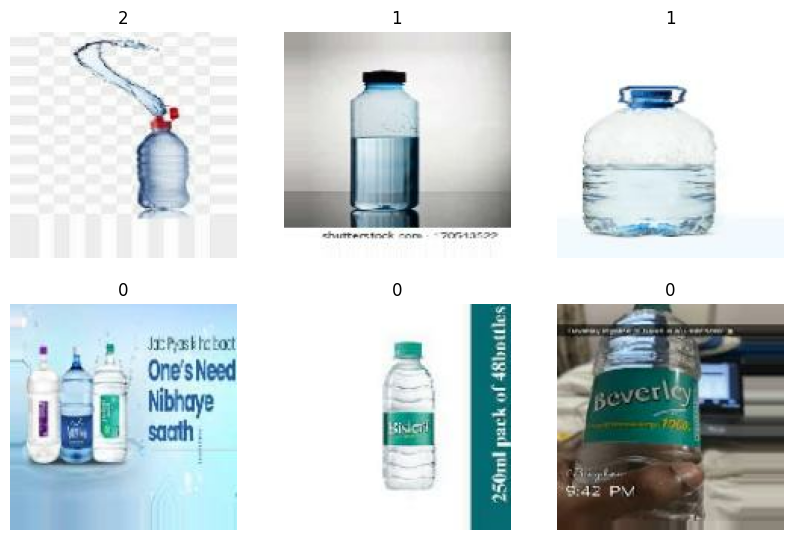

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
# Take 1 batch from the dataset
for images, labels in train_ds.take(1):
    for i in range(6): # Display first 6 images
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i])) # Shows the integer label
        plt.axis("off")
plt.show()

**Defining the CNN Architecture**

We define a Sequential model with Convolutional layers to extract features, followed by Max Pooling and Batch Normalization for stability.

In [7]:
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Dropout

# Define the Sequential Model
model = Sequential([
    # First Block
    layers.Conv2D(32, (5,5), activation='relu', padding='valid', input_shape=(150,150,3)),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Dropout(0.2),
    BatchNormalization(),
    
    # Second Block
    layers.Conv2D(32, (5,5), activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Dropout(0.2),
    BatchNormalization(),
    
    # Third Block
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Dropout(0.2),
    BatchNormalization(),
    
    # Fourth Block
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Dropout(0.2),
    BatchNormalization(),
    
    # Fifth Block
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    
    # Flatten and Dense Layers
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    # Output layer: 3 neurons for 3 classes
    layers.Dense(3, activation='softmax'),
])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 146, 146, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 73, 73, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 73, 73, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 73, 73, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 69, 69, 32)     │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 34, 34, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 34, 34, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 34, 34, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 7, 7, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 5, 5, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 226,499 (884.76 KB)

 Trainable params: 226,179 (883.51 KB)

 Non-trainable params: 320 (1.25 KB)

**Compiling and Training the Model**

We compile the model using the Adam optimizer. Note: We use sparse_categorical_crossentropy because our labels are integers (0, 1, 2), not one-hot vectors.

In [8]:
from tensorflow.keras.optimizers import Adam

# Compile the model
# We use 'sparse_categorical_crossentropy' because image_dataset_from_directory 
# returns integer labels (0, 1, 2) by default.
model.compile(
    optimizer=Adam(learning_rate=0.0001), 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

# Start training
history = model.fit(
    train_ds,
    validation_data=val_ds, 
    epochs=30
)

Epoch 1/30


I0000 00:00:1768907436.858030      74 service.cc:152] XLA service 0x78f3f8006140 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1768907436.858070      74 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1768907436.858076      74 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1768907437.577156      74 cuda_dnn.cc:529] Loaded cuDNN version 91002
2026-01-20 11:10:39.680123: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-20 11:10:39.819864: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


 10/171 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.3966 - loss: 1.5059

I0000 00:00:1768907445.335989      74 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


168/171 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4807 - loss: 1.0931

2026-01-20 11:10:49.112635: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-20 11:10:49.251114: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


171/171 ━━━━━━━━━━━━━━━━━━━━ 22s 62ms/step - accuracy: 0.4823 - loss: 1.0903 - val_accuracy: 0.5116 - val_loss: 1.0002
Epoch 2/30
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6296 - loss: 0.8317 - val_accuracy: 0.4302 - val_loss: 1.1506
Epoch 3/30
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6957 - loss: 0.7113 - val_accuracy: 0.4070 - val_loss: 1.1163
Epoch 4/30
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7447 - loss: 0.6076 - val_accuracy: 0.4419 - val_loss: 1.2392
Epoch 5/30
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7956 - loss: 0.5133 - val_accuracy: 0.4186 - val_loss: 1.3634
Epoch 6/30
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8127 - loss: 0.4831 - val_accuracy: 0.4535 - val_loss: 1.2595
Epoch 7/30
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8278 - loss: 0.4110 - val_accuracy: 0.4884 - val_loss: 1.4547
Epoch 8/30
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8430 - loss: 0.3875 - val_accuracy: 0.66

**Plotting Training Results**

Finally, we visualize the model's accuracy over the epochs to check for overfitting or underfitting.

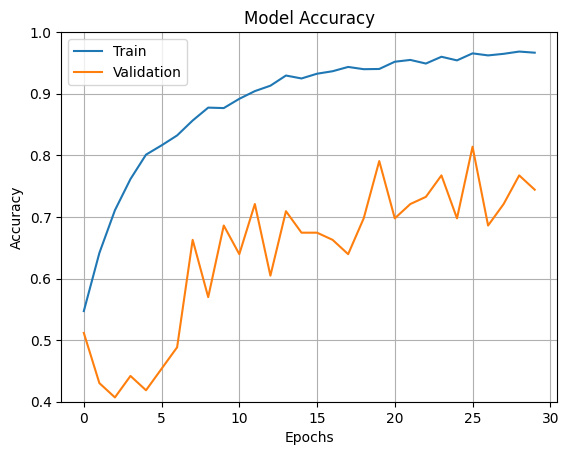

In [9]:
# Plot training accuracy
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy']) # Added validation accuracy for comparison
plt.axis(ymin=0.4, ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'])
plt.show()

**Acknowledgements** 
This notebook was inspired by the work of Ashmal Vayani. The original code has been refactored, updated to TensorFlow 2.x/Keras 3.x standards, and optimized for better performance.

Original Notebook: [Link](http://www.kaggle.com/code/ashmalvayani/96-67-accuracy-with-cnn-s)